In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dice_rl_plugins.value import get_get_policy_value_env, get_success_rate_env
from dice_rl_plugins.environment import test_env
from dice_rl_plugins.estimators.tabular.test import test_estimator, test_aux_estimates
from dice_rl_plugins.plot.tabular import plot_pvs, plot_sdc_errors
from dice_rl_plugins.estimators.get import (
    get_gammas_1, get_gammas_2,
    get_pv_s_OnPE, get_pv_s_OffPE, get_sdc_s, get_vaf_s, )

from dice_rl_plugins.estimators.tabular.aux_estimates.io import load_or_create_aux_estimates
from dice_rl_plugins.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_plugins.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_plugins.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_plugins.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from dice_rl_plugins.estimators.tabular.aux_estimates.errors import get_error_aux_estimates
from dice_rl_plugins.applications.gymnasium.frozen_lake.config import *
from dice_rl_plugins.applications.gymnasium.frozen_lake.transition_lister import (
    list_transitions_sample, list_transitions_exact, )

from utils.general import unpack
from utils.bedtime import computer_sleep

env
env_wrapped
env_wrapped_limited
dataset
data/dice_rl/frozenlake/datasets/num_experience=100000_seed=0_is_slippery=False/dataset-ctr.pkl
data/dice_rl/frozenlake/datasets/num_experience=100000_seed=0_is_slippery=True/dataset-ctr.pkl
model
Try loading model data/dice_rl/frozenlake/policies/total_timesteps=100000_is_slippery=False
Try loading model data/dice_rl/frozenlake/policies/total_timesteps=100000_is_slippery=True
target_policy
get_act_uniform
get_act_model
deterministic


100%|██████████| 64/64 [00:00<00:00, 11034.47it/s]


stochastic


100%|██████████| 64/64 [00:00<00:00, 8469.06it/s]

analytical_solver


In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_column", 100)

# Values

In [4]:
get_evaluation_policy_value = {}
evaluation_policy_rewards = {}

for k in K:
    v1, v2 = get_get_policy_value_env(
        env=env_wrapped_limited[k],
        get_act=get_act_model[k],
        num_trajectory=num_trajectory,
    )

    get_evaluation_policy_value[k] = v1
    evaluation_policy_rewards[k] = v2

In [5]:
for k in K:
    get_evaluation_policy_value[k].__name__ = "OnPE evaluation"

In [6]:
success_rates_uniform = {
    k: get_success_rate_env(
        env=env[k],
        get_act=get_act_uniform[k],
        num_trajectory=num_trajectory,
    )
        for k in K
}

success_rates_model = {
    k: get_success_rate_env(
        env=env[k],
        get_act=get_act_model[k],
        num_trajectory=num_trajectory,
    )
        for k in K
}

success_rate_uniform = { k: v[-1] for k, v in success_rates_uniform.items() }
success_rate_model   = { k: v[-1] for k, v in success_rates_model  .items() }

display(success_rate_uniform)
display(success_rate_model)

{'d': 0.014, 's': 0.015}

{'d': 1.0, 's': 0.646}

# Estimators

In [7]:
aux_estimates = {
    k: load_or_create_aux_estimates(
        aux_estimates_dir=aux_estimates_dir[k],
        dataset=dataset[k],
        target_policy=target_policy[k],
        by="experience",
    )
    for k in K
}

In [8]:
estimators_OnPE = get_evaluation_policy_value

estimators_VAFE = {
    k: [ TabularVafe(aux_estimates=aux_estimates[k], num_obs=16, n_act=4), ]
        for k in K
}

estimators_DICE = {}

for k in K:
    args = [ dataset[k], target_policy[k], aux_estimates[k], True, "experience", ]
    estimators_DICE[k] = [ TabularDice(*args), TabularDualDice(*args), TabularGradientDice(*args), ]

estimators_OffPE = {
    k: estimators_VAFE[k] + estimators_DICE[k]
        for k in K
}

# `get_pvs` & `get_sdcs`

In [9]:
gammas_1 = get_gammas_1()
gammas_2 = get_gammas_2()

projected = True
modified = True
lam = 1e-6

In [439]:
# pvs_OnPE

pvs_OnPE_1 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_1,
    )
        for k in K
}

pvs_OnPE_2 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_2,
    )
        for k in K
}

OnPE evaluation


100%|██████████| 9/9 [00:00<00:00, 3973.97it/s]


OnPE evaluation


100%|██████████| 9/9 [00:00<00:00, 2264.20it/s]


OnPE evaluation


100%|██████████| 17/17 [00:00<00:00, 27029.25it/s]


OnPE evaluation


100%|██████████| 17/17 [00:00<00:00, 17688.70it/s]


In [440]:
# pvs_OffPE

pvs_VAFE_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_VAFE_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_s_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_s_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_w_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_w_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_1 = { False: pvs_DICE_s_1, True: pvs_DICE_w_1, }
pvs_DICE_2 = { False: pvs_DICE_s_2, True: pvs_DICE_w_2, }

TabularVafe


100%|██████████| 9/9 [00:00<00:00, 37.43it/s]


TabularVafe


100%|██████████| 9/9 [00:00<00:00, 201.10it/s]


TabularVafe


100%|██████████| 17/17 [00:00<00:00, 220.28it/s]


TabularVafe


100%|██████████| 17/17 [00:00<00:00, 631.15it/s]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:00<00:00, 21.30it/s]


TabularDualDice


  0%|          | 0/9 [00:00<?, ?it/s]/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/tabular_dice.py:38: UserWarning: negative sdc value encountered
  warnings.warn("negative sdc value encountered", UserWarning)
100%|██████████| 9/9 [00:00<00:00, 31.89it/s]


TabularGradientDice


100%|██████████| 9/9 [00:00<00:00, 26.22it/s]


TabularDice


100%|██████████| 9/9 [00:00<00:00, 38.63it/s]


TabularDualDice


100%|██████████| 9/9 [00:00<00:00, 14.32it/s]


TabularGradientDice


100%|██████████| 9/9 [00:00<00:00, 18.03it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 24.81it/s]


TabularDualDice


100%|██████████| 17/17 [00:01<00:00, 16.19it/s]


TabularGradientDice


100%|██████████| 17/17 [00:00<00:00, 28.97it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 40.95it/s]


TabularDualDice


100%|██████████| 17/17 [00:00<00:00, 18.41it/s]


TabularGradientDice


100%|██████████| 17/17 [00:00<00:00, 35.52it/s]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:00<00:00, 51.06it/s]


TabularDualDice


100%|██████████| 9/9 [00:00<00:00, 29.74it/s]


TabularGradientDice


100%|██████████| 9/9 [00:00<00:00, 32.19it/s]


TabularDice


100%|██████████| 9/9 [00:00<00:00, 20.10it/s]


TabularDualDice


100%|██████████| 9/9 [00:00<00:00, 52.67it/s]


TabularGradientDice


100%|██████████| 9/9 [00:00<00:00, 34.72it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 20.81it/s]


TabularDualDice


100%|██████████| 17/17 [00:00<00:00, 19.42it/s]


TabularGradientDice


100%|██████████| 17/17 [00:00<00:00, 22.40it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 39.19it/s]


TabularDualDice


100%|██████████| 17/17 [00:00<00:00, 28.13it/s]


TabularGradientDice


100%|██████████| 17/17 [00:00<00:00, 22.47it/s]


In [10]:
# sdcs_DICE

sdcs_DICE_1 = {
    k: get_sdc_s(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_1,
        projected=projected,
        modified=modified, lam=lam,
    )
        for k in K
}

sdcs_DICE_2 = {
    k: get_sdc_s(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_2,
        projected=projected,
        modified=modified, lam=lam,
    )
        for k in K
}

In [443]:
# vafs_VAFE

vafs_1 = {
    k: get_vaf_s(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_1,
        projected=projected,
    )
        for k in K
}

vafs_2 = {
    k: get_vaf_s(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_2,
        projected=projected,
    )
        for k in K
}

TabularVafe


100%|██████████| 9/9 [00:00<00:00, 129.06it/s]


TabularVafe


100%|██████████| 9/9 [00:00<00:00, 430.76it/s]


TabularVafe


100%|██████████| 17/17 [00:00<00:00, 340.04it/s]


TabularVafe


100%|██████████| 17/17 [00:00<00:00, 478.21it/s]


In [11]:
# pvs_exact, vafs_exact, sdcs_exact

pvs_exact_1 = {}; vafs_exact_1 = {}; sdcs_exact_1 = {}

for k in K:
    pv_list = []
    vaf_list = []
    sdc_list = []

    for gamma in gammas_1:
        pv, (vaf, sdc), _ = analytical_solver[k].solve(gamma) # type: ignore

        pv_list .append(pv)
        sdc_list.append(sdc)

    pvs_exact_1[k] = np.array(pv_list)
    vafs_exact_1[k] = np.array(vaf_list)
    sdcs_exact_1[k] = np.array(sdc_list)

# -------------------------------- #

pvs_exact_2 = {}; vafs_exact_2 = {}; sdcs_exact_2 = {}

for k in K:
    pv_list = []
    sdc_list = []

    for gamma in gammas_2:
        pv, (vaf, sdc), _ = analytical_solver[k].solve(gamma) # type: ignore

        pv_list .append(pv)
        sdc_list.append(sdc)

    pvs_exact_2[k] = np.array(pv_list)
    vafs_exact_2[k] = np.array(vaf_list)
    sdcs_exact_2[k] = np.array(sdc_list)

In [445]:
# pv_OnPE

pv_OnPE = {}

for k in K:
    pv_OnPE[k] = evaluation_policy_rewards[k].mean(axis=1).mean()

In [12]:
# pv_DICE, sdc_DICE, ev_DICE

pv_DICE_s = {}
pv_DICE_w = {}
sdc_DICE = {}
ev_DICE = {}

for k in K:
    pv_hat, *_ = estimators_DICE[k][0].solve(
        gamma=1, projected=projected, weighted=False, modified=modified)

    pv_DICE_s[k] = pv_hat

    pv_hat, *_ = estimators_DICE[k][0].solve(
        gamma=1, projected=projected, weighted=True, modified=modified)

    pv_DICE_w[k] = pv_hat

    sdc_hat, info = estimators_DICE[k][0].solve_sdc(
        gamma=1, projected=projected, modified=modified)

    sdc_DICE[k] = sdc_hat
    ev_DICE[k] = info["ev_hat"]

In [13]:
# pv_exact, sdc_exact, ev_exact

pv_exact = {}
sdc_exact = {}
ev_exact = {}

for k in K:
    pv, sdc, info = analytical_solver[k].solve(
        gamma=1, primal_dual="dual") # type: ignore

    pv_exact[k] = pv
    sdc_exact[k] = sdc
    ev_exact[k] = info["ev"]

pv_DICE = { False: pv_DICE_w, True: pv_DICE_w, }

In [464]:
ev_DICE

{'d': (0.9999951267269968+0j), 's': (0.9999983041250038+0j)}

In [465]:
ev_exact

{'d': (1.000000020944715+0j), 's': (0.9999999081317305+0j)}

# Plot

In [14]:
env_title = "Frozen Lake"

colors_OnPE = ["grey"]
colors_VAFE = ["blue"]
colors_DICE = ["orange", "green", "red"]
colors_OffPE = colors_VAFE + colors_DICE
color_ref = "black"

markers_OnPE = ["^"]
markers_VAFE = ["1"]
markers_DICE = ["2", "3", "4"]
markers_OffPE = markers_VAFE + markers_DICE
marker_ref = "."

colors = colors_OnPE + colors_OffPE + [color_ref]
colors_lim = ["grey", "orange", "black"]

markers = markers_OnPE + markers_OffPE + [marker_ref]
markers_lim = ["^", "2", "."]

## Policy Values

In [566]:
def plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, save_dir,
    ):

    estimators = [ estimators_OnPE[k], ] + estimators_OffPE[k]
    if not errors: estimators.append( analytical_solver[k] )
    #
    c  = colors     if not errors else colors[:-1]
    cl = colors_lim if not errors else colors_lim[:-1]
    #
    m  = markers     if not errors else markers[:-1]
    ml = markers_lim if not errors else markers_lim[:-1]
    #
    kind = "PV Errors" if errors else "PVs"
    suptitle = f"{kind} - {env_title} - {names[k]}"
    scale_y = errors

    plot_pvs(
        estimators=estimators,
        gammas=gammas,
        projected=projected,
        weighted=weighted,
        modified=modified,
        lam=lam,
        #
        pvs=pvs,
        pv_ref=pv_ref,
        pv_lims=pv_lims,
        pv_lim_ref=pv_lim_ref,
        #
        labels=None,
        #
        colors=c,
        colors_lim=cl,
        #
        markers=m,
        markers_lim=ml,
        #
        suptitle=suptitle,
        one_minus_gamma=one_minus_gamma,
        errors=errors,
        scale_x=scale_x,
        scale_y=scale_y,
        scale_pv=False,
        ylim=None,
        legend=True,
        save_dir=save_dir,
)


def plot_pvs_wrapped_1(k, weighted, errors):

    gammas = gammas_1
    #
    pvs = [ pvs_OnPE_1[k], ] + list(pvs_VAFE_1[k]) + list(pvs_DICE_1[weighted][k])
    if not errors: pvs.append( pvs_exact_1[k] )
    pv_ref = pvs_exact_1[k]
    pv_lims = None
    # pv_lims = [ pv_OnPE[k], pv_DICE[weighted][k], ]
    # if not errors: pv_lims.append( pv_exact[k] )
    pv_lim_ref = pv_exact[k]
    #
    one_minus_gamma = False
    scale_x = False
    #
    save_dir = os.path.join(save_dir_images, "gamma=low")

    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, save_dir,
    )

def plot_pvs_wrapped_2(k, weighted, errors):

    gammas = gammas_2
    #
    pvs = [ pvs_OnPE_2[k], ] + list(pvs_VAFE_2[k]) + list(pvs_DICE_2[weighted][k])
    if not errors: pvs.append( pvs_exact_2[k] )
    pv_ref = pvs_exact_2[k]
    # pv_lims = None
    pv_lims = [ pv_OnPE[k], pv_DICE[weighted][k], ]
    if not errors: pv_lims.append( pv_exact[k] )
    pv_lim_ref = pv_exact[k]
    #
    one_minus_gamma = True
    scale_x = True
    #
    save_dir = os.path.join(save_dir_images, "gamma=high")


    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims, pv_lim_ref,
        one_minus_gamma, scale_x, save_dir,
    )

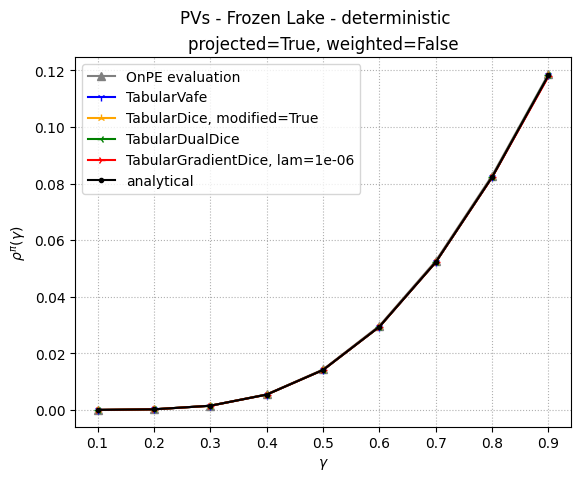

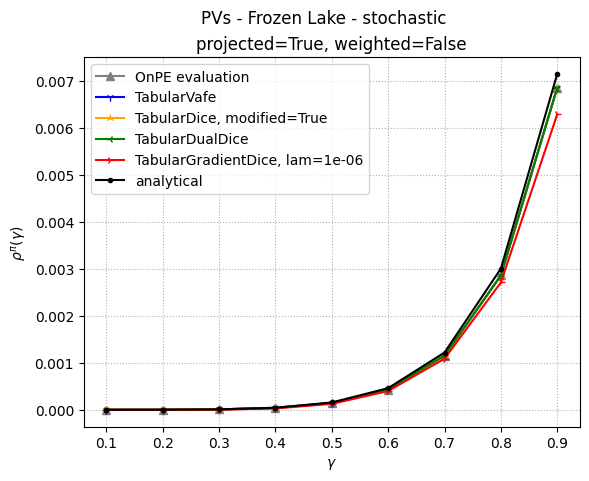

# ---------------------------------------------------------------- #


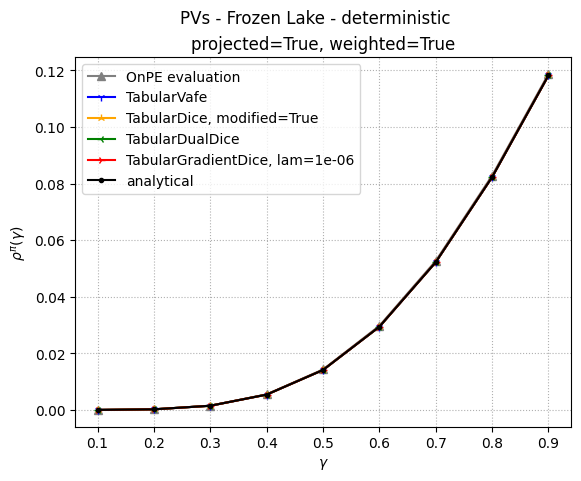

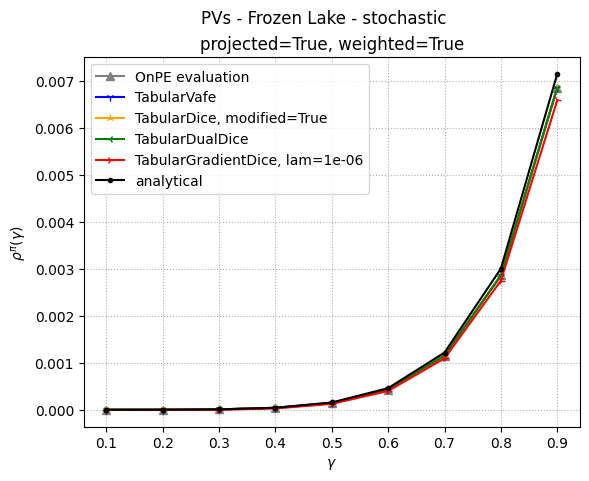

In [561]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=False)

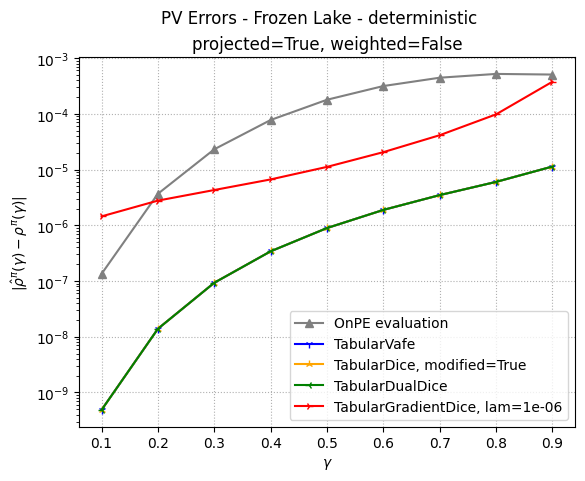

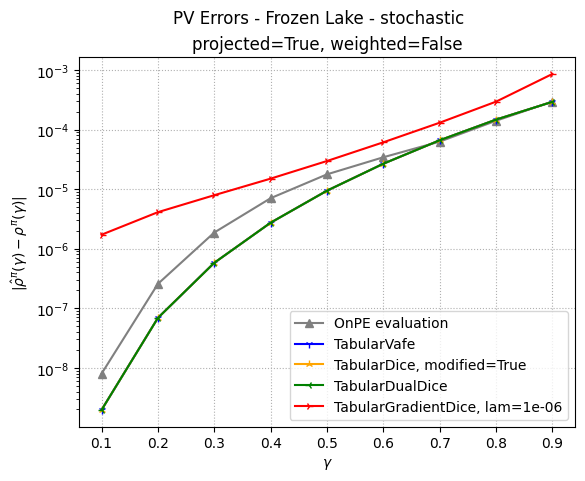

# ---------------------------------------------------------------- #


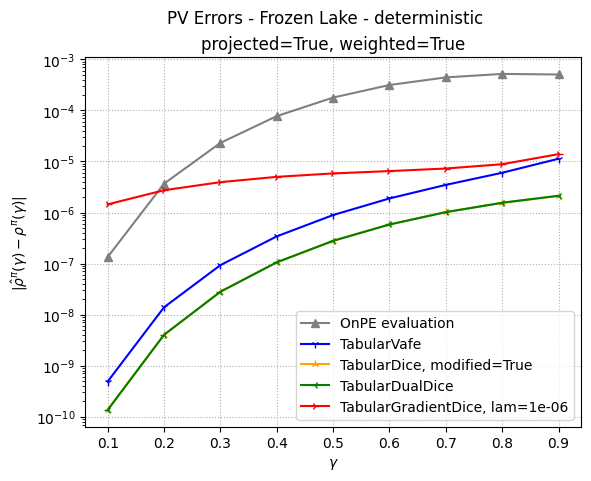

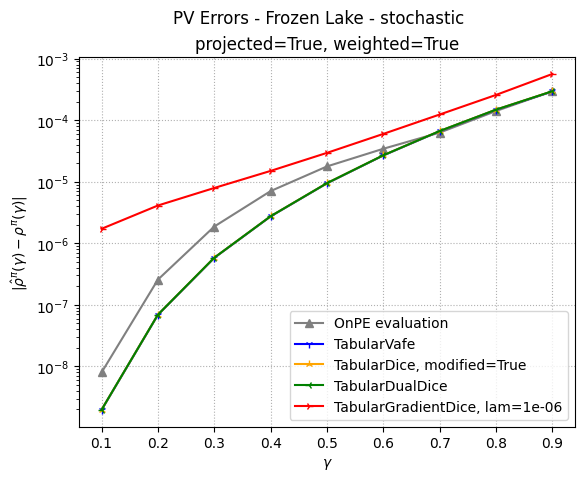

In [562]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=True)

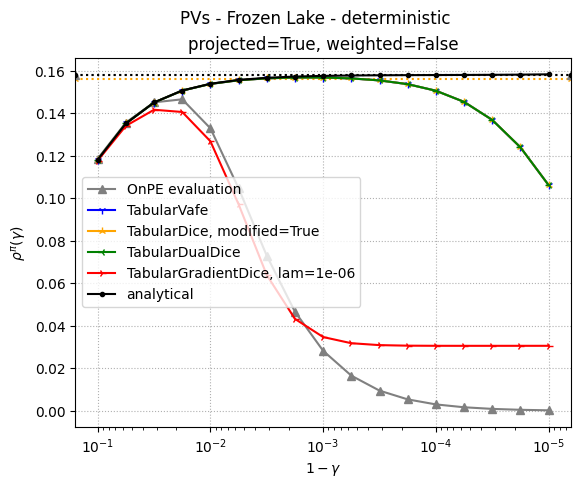

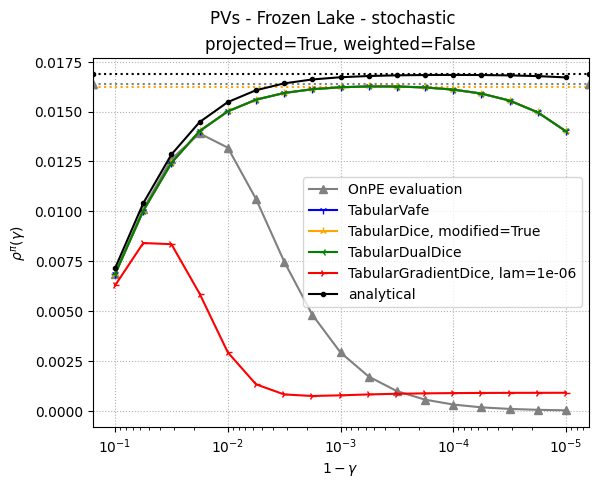

# ---------------------------------------------------------------- #


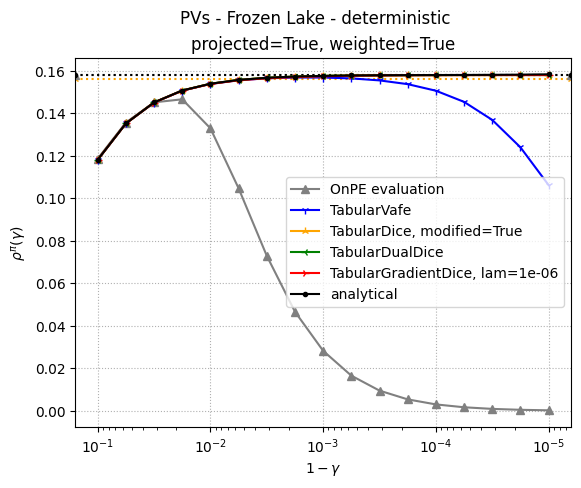

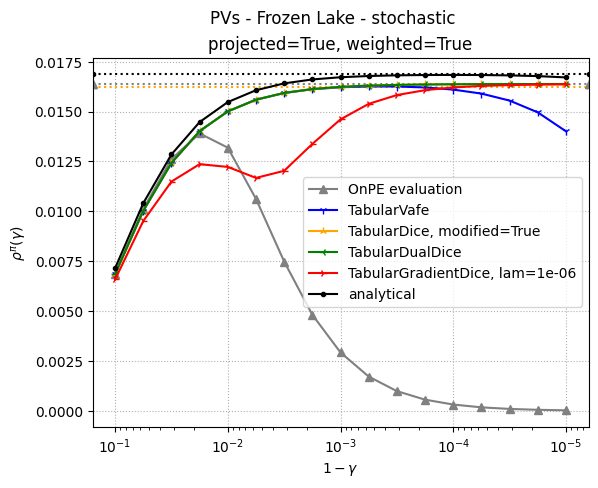

In [563]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=False)

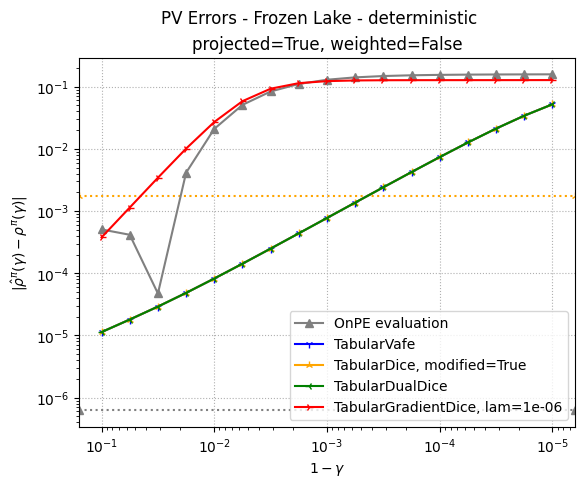

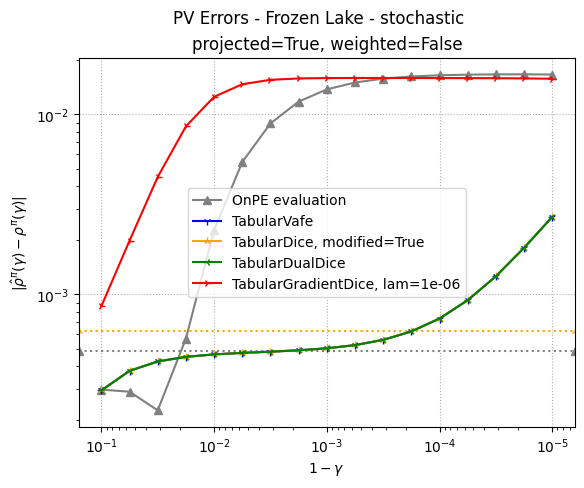

# ---------------------------------------------------------------- #


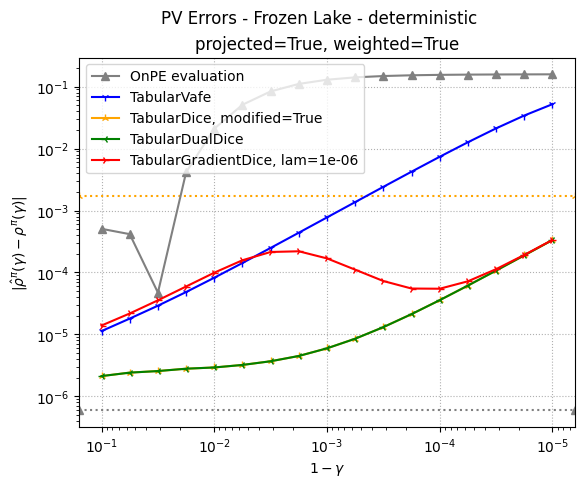

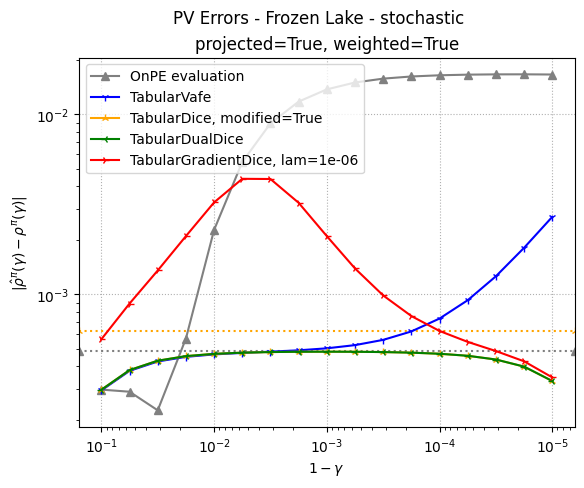

In [564]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=True)

## Stationary Distribution Corrections

In [15]:
def plot_sdc_errors_wrapped(
        k,
        gammas, sdcs, sdc_lims, sdc_ref, sdc_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir):

    estimators = estimators_DICE[k]
    #
    c = colors_DICE
    cl = [ colors_DICE[0], ]
    #
    m = markers_DICE
    ml = [ markers_DICE[0], ]
    #
    kind = "SDC MSEs"
    suptitle = f"{kind} - {env_title} - {names[k]}"

    plot_sdc_errors(
        estimators=estimators,
        gammas=gammas,
        projected=projected,
        modified=modified,
        lam=lam,
        #
        sdcs=sdcs,
        sdc_lims=sdc_lims,
        sdc_ref=sdc_ref,
        sdc_lim_ref=sdc_lim_ref,
        #
        colors=c,
        colors_lim=cl,
        #
        markers=m,
        markers_lim=ml,
        #
        suptitle=suptitle,
        one_minus_gamma=one_minus_gamma,
        scale_x=scale_x,
        scale_y=scale_y,
        ylim=None,
        legend=True,
        save_dir=save_dir,
    )

def plot_sdc_errors_wrapped_1(k):

    gammas = gammas_1
    #
    sdcs = sdcs_DICE_1[k]
    sdc_lims = None
    #
    sdc_ref = sdcs_exact_1[k]
    sdc_lim_ref = None
    #
    one_minus_gamma = False
    scale_x = False
    scale_y = False
    save_dir = os.path.join(save_dir_images, "gamma=low")

    plot_sdc_errors_wrapped(
        k,
        gammas, sdcs, sdc_lims, sdc_ref, sdc_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir,
    )

def plot_sdc_errors_wrapped_2(k):

    gammas = gammas_2
    #
    sdcs = sdcs_DICE_2[k]
    sdc_lims = [ sdc_DICE[k], ]
    #
    sdc_ref = sdcs_exact_2[k]
    sdc_lim_ref = sdc_exact[k]
    #
    one_minus_gamma = True
    scale_x = True
    scale_y = True
    save_dir = os.path.join(save_dir_images, "gamma=high")

    plot_sdc_errors_wrapped(
        k,
        gammas, sdcs, sdc_lims, sdc_ref, sdc_lim_ref,
        one_minus_gamma, scale_x, scale_y, save_dir,
    )

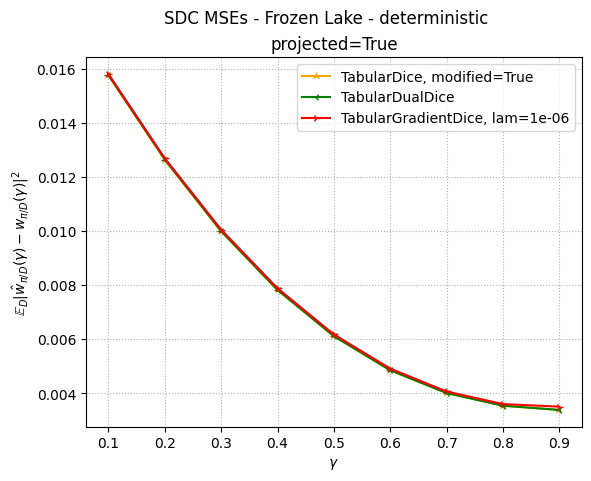

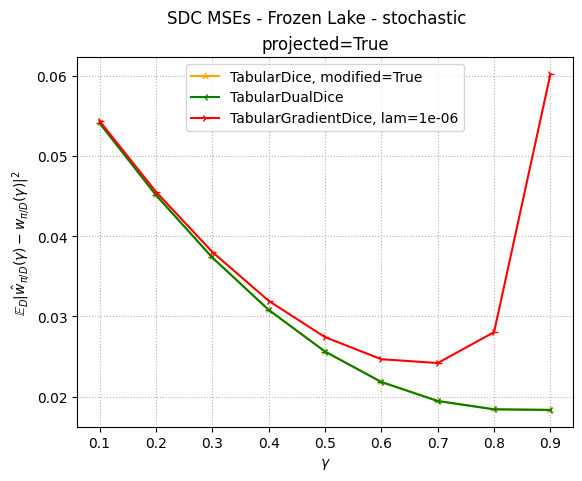

In [16]:
for k in K:
    plot_sdc_errors_wrapped_1(k)

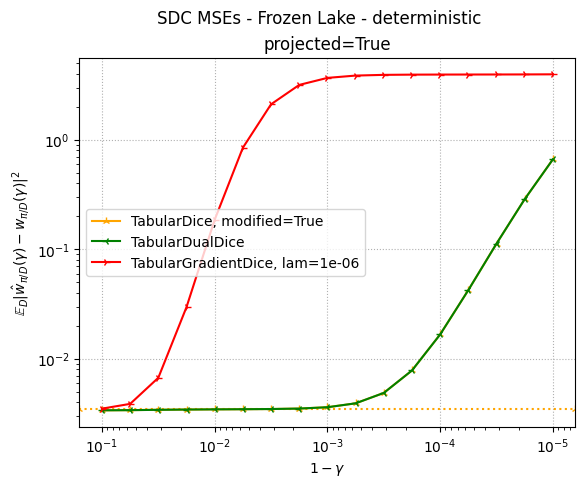

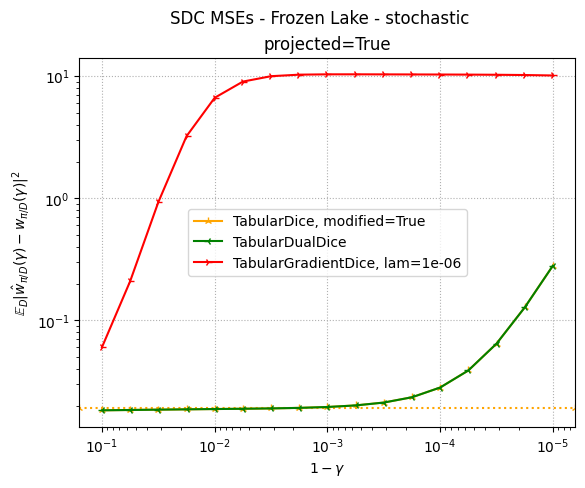

In [18]:
for k in K:
    plot_sdc_errors_wrapped_2(k)

# Test

## `env` & `env_wrapped`

In [42]:
def execute_test_env(env, get_act, num_trajectory, max_trajectory_length=None):
    for k in K:
        print("#", "-"*64, "#", "\n")
        print(names[k]); print()
        data = test_env(
            env=env[k],
            get_act=get_act[k],
            num_trajectory=num_trajectory,
            max_trajectory_length=max_trajectory_length,
            verbosity=2,
        )
        display(data)

In [43]:
execute_test_env(
    env=env, get_act=get_act_uniform,
    num_trajectory=2,
)

# ---------------------------------------------------------------- # 

deterministic

0, 3 0.0
0, 3 0.0
0, 0 0.0
0, 0 0.0
0, 3 0.0
0, 0 0.0
0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 3 0.0
2, 3 0.0
2, 0 0.0
1, 3 0.0
1, 1 0.0
5, terminated

0, 0 0.0
0, 3 0.0
0, 3 0.0
0, 0 0.0
0, 3 0.0
0, 2 0.0
1, 0 0.0
0, 0 0.0
0, 2 0.0
1, 2 0.0
2, 0 0.0
1, 2 0.0
2, 0 0.0
1, 0 0.0
0, 0 0.0
0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 2 0.0
7, terminated



{'distinct_absolute': (5.0, 0.0),
 'distinct_relative': (0.29166666666666663, 0.04166666666666666),
 'all': (17.5, 2.5)}

# ---------------------------------------------------------------- # 

stochastic

0, 0 0.0
0, 1 0.0
1, 1 0.0
2, 1 0.0
3, 1 0.0
3, 1 0.0
3, 1 0.0
2, 0 0.0
1, 3 0.0
0, 0 0.0
4, 2 0.0
8, 0 0.0
8, 1 0.0
12, terminated

0, 1 0.0
0, 3 0.0
0, 0 0.0
0, 3 0.0
0, 1 0.0
4, 1 0.0
8, 1 0.0
12, terminated



{'distinct_absolute': (5.5, 1.5),
 'distinct_relative': (0.5, 0.0),
 'all': (11.0, 3.0)}

In [44]:
execute_test_env(
    env=env_wrapped, get_act=get_act_uniform,
    num_trajectory=1, max_trajectory_length=24,
)

# ---------------------------------------------------------------- # 

deterministic

0, 1 0.0
4, 0 0.0
4, 1 0.0
8, 3 0.0
4, 1 0.0
8, 1 0.0
0, 1 0.0
4, 0 0.0
4, 2 0.0
0, 0 0.0
0, 2 0.0
1, 3 0.0
1, 1 0.0
0, 2 0.0
1, 0 0.0
0, 0 0.0
0, 2 0.0
1, 3 0.0
1, 1 0.0
0, 3 0.0
0, 3 0.0
0, 3 0.0
0, 0 0.0
0, 2 0.0
1, truncated



{'distinct_absolute': (4.0, 0.0),
 'distinct_relative': (0.16, 0.0),
 'all': (25.0, 0.0)}

# ---------------------------------------------------------------- # 

stochastic

0, 3 0.0
0, 0 0.0
0, 0 0.0
0, 2 0.0
4, 2 0.0
0, 0 0.0
4, 2 0.0
0, 1 0.0
4, 3 0.0
0, 2 0.0
1, 3 0.0
1, 3 0.0
2, 2 0.0
6, 1 0.0
0, 3 0.0
0, 2 0.0
0, 1 0.0
0, 1 0.0
1, 2 0.0
0, 3 0.0
0, 2 0.0
1, 0 0.0
0, 2 0.0
4, 0 0.0
0, truncated



{'distinct_absolute': (5.0, 0.0),
 'distinct_relative': (0.2, 0.0),
 'all': (25.0, 0.0)}

In [45]:
execute_test_env(
    env=env, get_act=get_act_model,
    num_trajectory=2,
)

# ---------------------------------------------------------------- # 

deterministic

0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 1 0.0
10, 1 0.0
14, 0 0.0
13, 2 0.0
14, 2 1.0
15, terminated

0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 1 0.0
10, 1 0.0
14, 0 0.0
13, 2 0.0
14, 2 1.0
15, terminated



{'distinct_absolute': (8.0, 0.0),
 'distinct_relative': (0.8888888888888888, 0.0),
 'all': (9.0, 0.0)}

# ---------------------------------------------------------------- # 

stochastic

0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
8, 3 0.0
9, 1 0.0
13, 2 0.0
13, 2 0.0
13, 2 0.0
13, 2 0.0
9, 1 0.0
13, 2 0.0
9, 1 0.0
8, 3 0.0
4, 0 0.0
8, 3 0.0
9, 1 0.0
13, 2 0.0
9, 1 0.0
8, 3 0.0
4, 0 0.0
0, 0 0.0
0, 2 0.0
1, 2 0.0
1, 3 0.0
2, 0 0.0
1, 3 0.0
2, 0 0.0
2, 0 0.0
6, 1 0.0
10, 0 0.0
9, 1 0.0
10, 0 0.0
14, 1 1.0
15, terminated

0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
8, 3 0.0
9, 1 0.0
8, 3 0.0
9, 1 0.0
13, 2 0.0
14, 1 0.0
14, 1 1.0
15, terminated



{'distinct_absolute': (9.0, 2.0),
 'distinct_relative': (0.3469079939668175, 0.06485671191553544),
 'all': (28.0, 11.0)}

In [46]:
execute_test_env(
    env=env_wrapped, get_act=get_act_model,
    num_trajectory=1, max_trajectory_length=24,
)

# ---------------------------------------------------------------- # 

deterministic

0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 1 0.0
10, 1 0.0
14, 2 1.0
0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 1 0.0
10, 1 0.0
14, 2 1.0
0, 2 0.0
1, 2 0.0
2, 1 0.0
6, 1 0.0
10, 1 0.0
14, 2 1.0
0, 1 0.0
4, 1 0.0
8, 2 0.0
9, 1 0.0
13, 2 0.0
14, 2 1.0
0, truncated



{'distinct_absolute': (10.0, 0.0),
 'distinct_relative': (0.4, 0.0),
 'all': (25.0, 0.0)}

# ---------------------------------------------------------------- # 

stochastic

0, 0 0.0
4, 0 0.0
8, 3 0.0
8, 3 0.0
8, 3 0.0
4, 0 0.0
0, 0 0.0
4, 0 0.0
8, 3 0.0
4, 0 0.0
4, 0 0.0
4, 0 0.0
0, 0 0.0
4, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
4, 0 0.0
8, 3 0.0
8, 3 0.0
9, truncated



{'distinct_absolute': (4.0, 0.0),
 'distinct_relative': (0.16, 0.0),
 'all': (25.0, 0.0)}

## `transitions_lister`

In [47]:
def list_transitions(transitions_sample, kind):
    for k in K:
        print("#", "-"*64, "#", "\n")
        print(names[k]); print()

        if kind == "sample": f = list_transitions_sample
        if kind == "exact":  f = list_transitions_exact

        df = f(transitions_sample[k])
        display(df)

In [50]:
list_transitions(transitions_sample_env, "sample")

# ---------------------------------------------------------------- # 

deterministic



,obs,act,obs_next,rew
0,0,0,"[(0, 1000)]","[(0.0, 1000)]"
1,0,1,"[(4, 1000)]","[(0.0, 1000)]"
2,0,2,"[(1, 1000)]","[(0.0, 1000)]"
3,0,3,"[(0, 1000)]","[(0.0, 1000)]"
4,1,0,"[(0, 1000)]","[(0.0, 1000)]"
5,1,1,"[(0, 1000)]","[(0.0, 1000)]"
6,1,2,"[(2, 1000)]","[(0.0, 1000)]"
7,1,3,"[(1, 1000)]","[(0.0, 1000)]"
8,2,0,"[(1, 1000)]","[(0.0, 1000)]"
9,2,1,"[(6, 1000)]","[(0.0, 1000)]"


# ---------------------------------------------------------------- # 

stochastic



,obs,act,obs_next,rew
0,0,0,"[(0, 638), (4, 362)]","[(0.0, 1000)]"
1,0,1,"[(0, 361), (1, 326), (4, 313)]","[(0.0, 1000)]"
2,0,2,"[(0, 303), (1, 349), (4, 348)]","[(0.0, 1000)]"
3,0,3,"[(0, 662), (1, 338)]","[(0.0, 1000)]"
4,1,0,"[(0, 662), (1, 338)]","[(0.0, 1000)]"
5,1,1,"[(0, 648), (2, 352)]","[(0.0, 1000)]"
6,1,2,"[(0, 342), (1, 352), (2, 306)]","[(0.0, 1000)]"
7,1,3,"[(0, 329), (1, 323), (2, 348)]","[(0.0, 1000)]"
8,2,0,"[(1, 320), (2, 327), (6, 353)]","[(0.0, 1000)]"
9,2,1,"[(1, 331), (3, 346), (6, 323)]","[(0.0, 1000)]"


In [51]:
# list_transitions(transitions_sample_dataset, "sample")

In [52]:
list_transitions(transitions_exact_env, "exact")

# ---------------------------------------------------------------- # 

deterministic



,obs,act,obs_next,probs,rew
0,0,0,0,1,0
1,0,1,4,1,0
2,0,2,1,1,0
3,0,3,0,1,0
4,1,0,0,1,0
5,1,1,0,1,0
6,1,2,2,1,0
7,1,3,1,1,0
8,2,0,1,1,0
9,2,1,6,1,0


# ---------------------------------------------------------------- # 

stochastic



,obs,act,obs_next,probs,rew
0,0,0,"[0, 4]","[2/3, 1/3]",0
1,0,1,"[0, 1, 4]","[1/3, 1/3, 1/3]",0
2,0,2,"[0, 1, 4]","[1/3, 1/3, 1/3]",0
3,0,3,"[0, 1]","[2/3, 1/3]",0
4,1,0,"[0, 1]","[2/3, 1/3]",0
5,1,1,"[0, 2]","[2/3, 1/3]",0
6,1,2,"[0, 1, 2]","[1/3, 1/3, 1/3]",0
7,1,3,"[0, 1, 2]","[1/3, 1/3, 1/3]",0
8,2,0,"[1, 2, 6]","[1/3, 1/3, 1/3]",0
9,2,1,"[1, 3, 6]","[1/3, 1/3, 1/3]",0


In [53]:
# list_transitions(transitions_exact_dataset, "exact")

## Estimators

/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/test.py:194: DeprecationWarning: invalid escape sequence '\q'
  


(s, a) visited:
{'absolute': 64, 'relative': 1.0}
(s, a) not visited:
{'absolute': 0, 'relative': 0.0}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



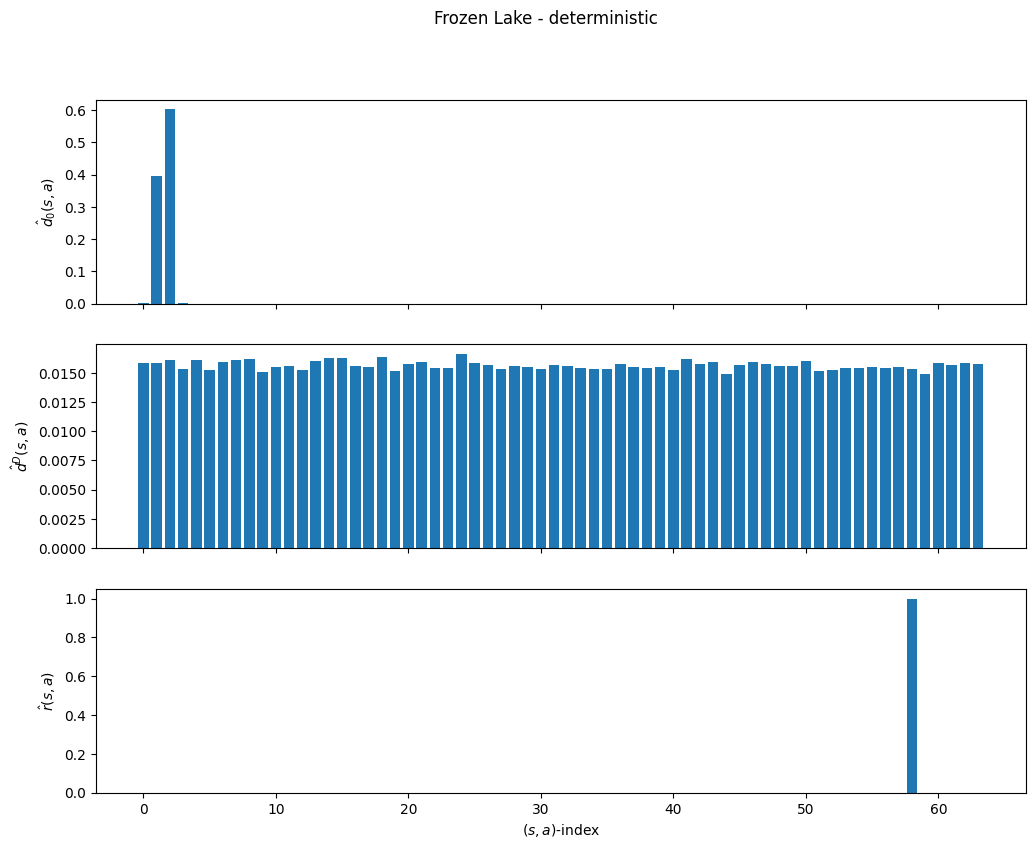

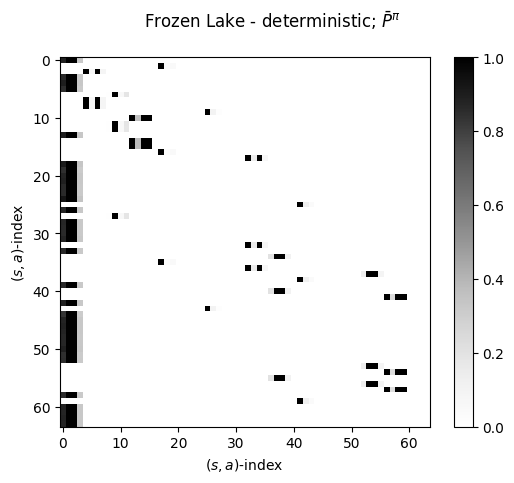

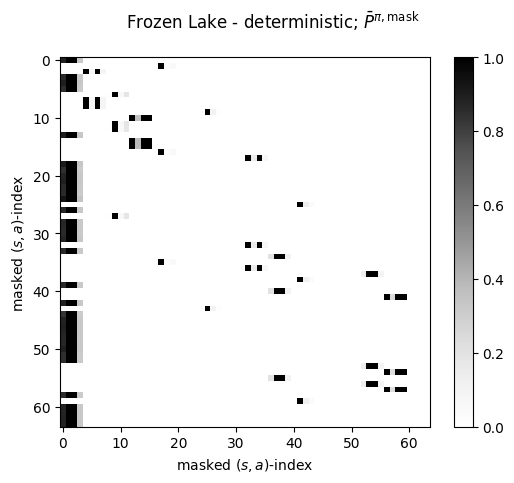

# ---------------------------------------------------------------- # 



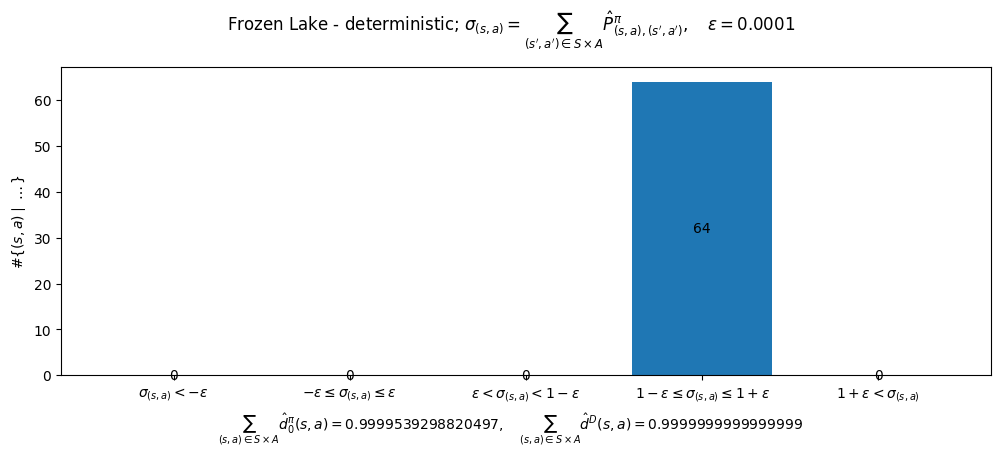

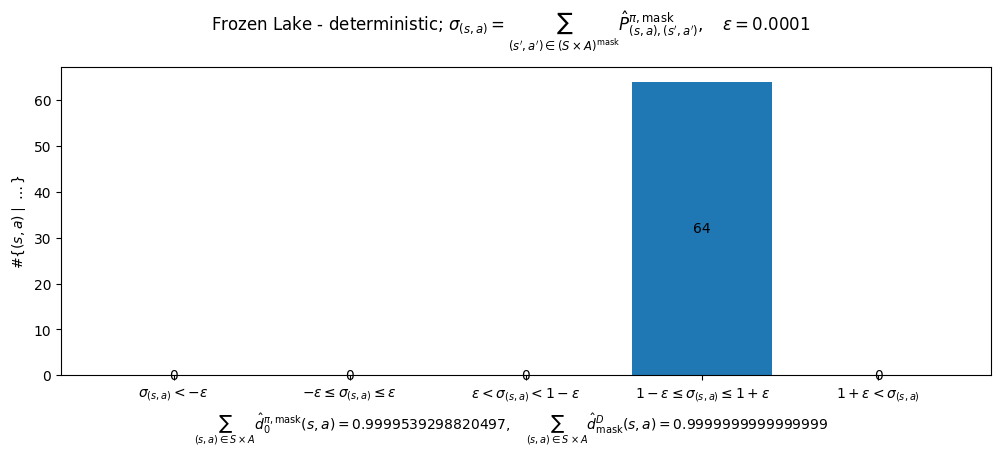

# ---------------------------------------------------------------- # 



In [589]:
k = "d"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Frozen Lake - {names[k]}",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

(s, a) visited:
{'absolute': 64, 'relative': 1.0}
(s, a) not visited:
{'absolute': 0, 'relative': 0.0}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



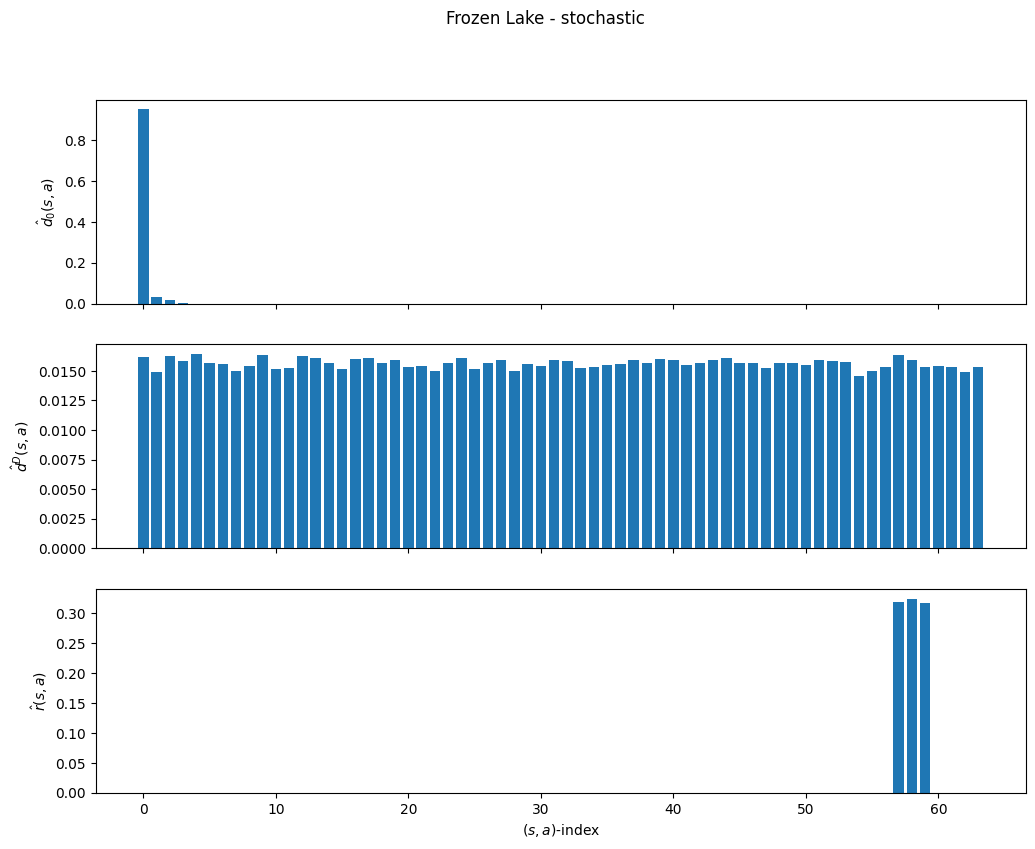

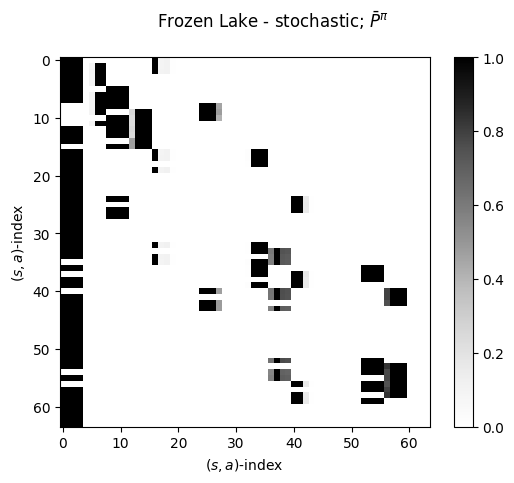

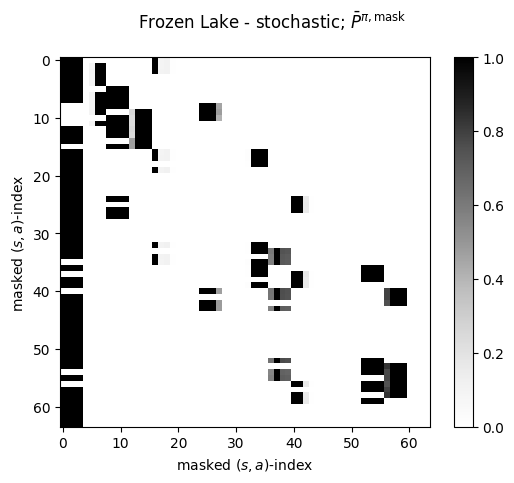

# ---------------------------------------------------------------- # 



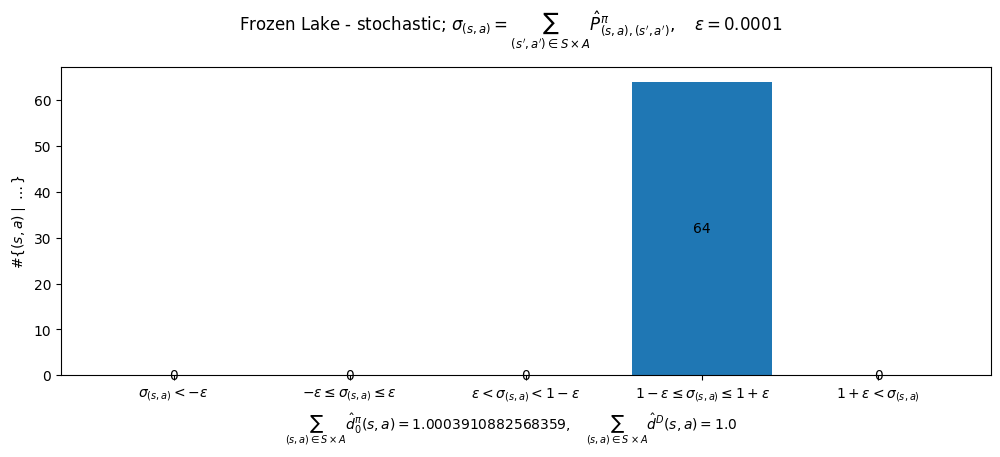

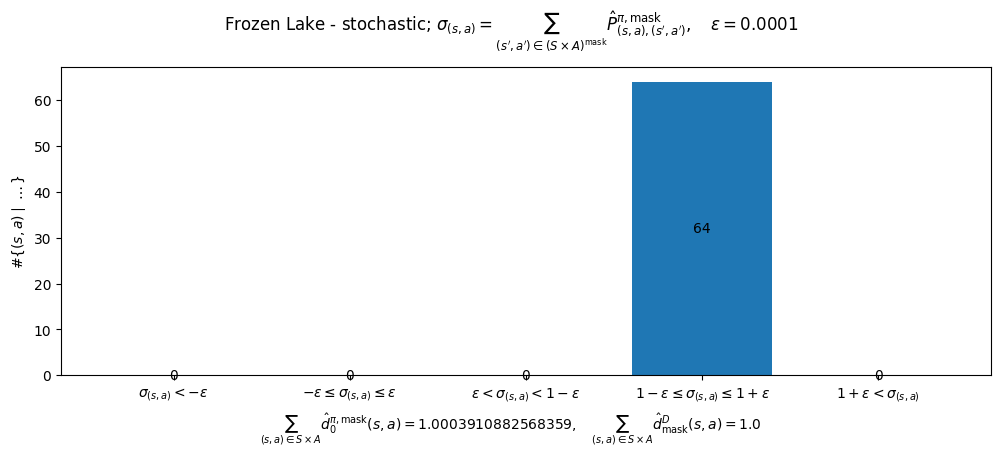

# ---------------------------------------------------------------- # 



In [590]:
k = "s"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Frozen Lake - {names[k]}",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

pv=0.11820856481790543
np.dot(sdc_hat, dD_hat)=0.9999221925030817



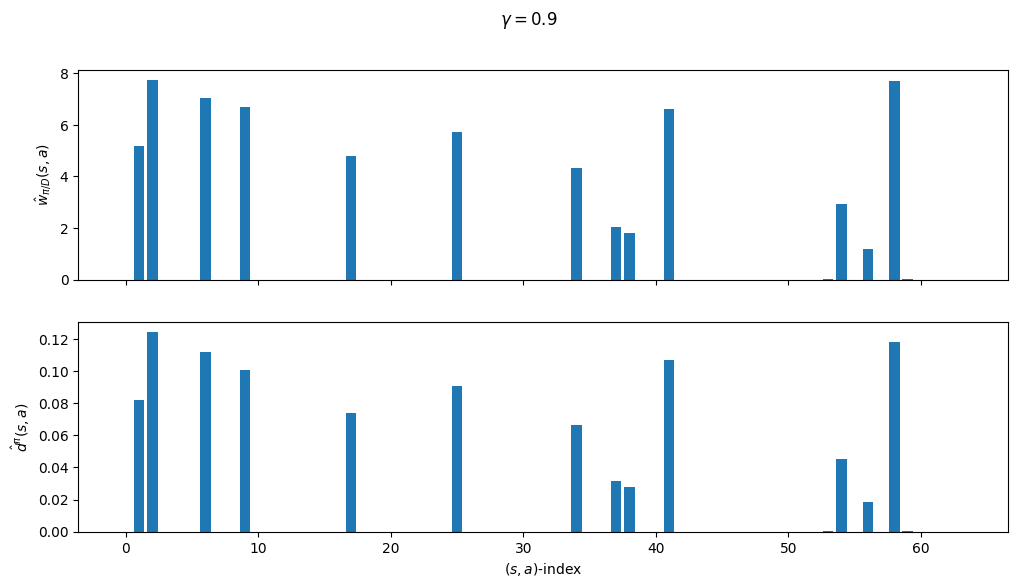

In [586]:
test_estimator(
    estimator_DICE=estimators_DICE["d"][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

pv=0.00685409689322114
np.dot(sdc_hat, dD_hat)=1.0003738501990334



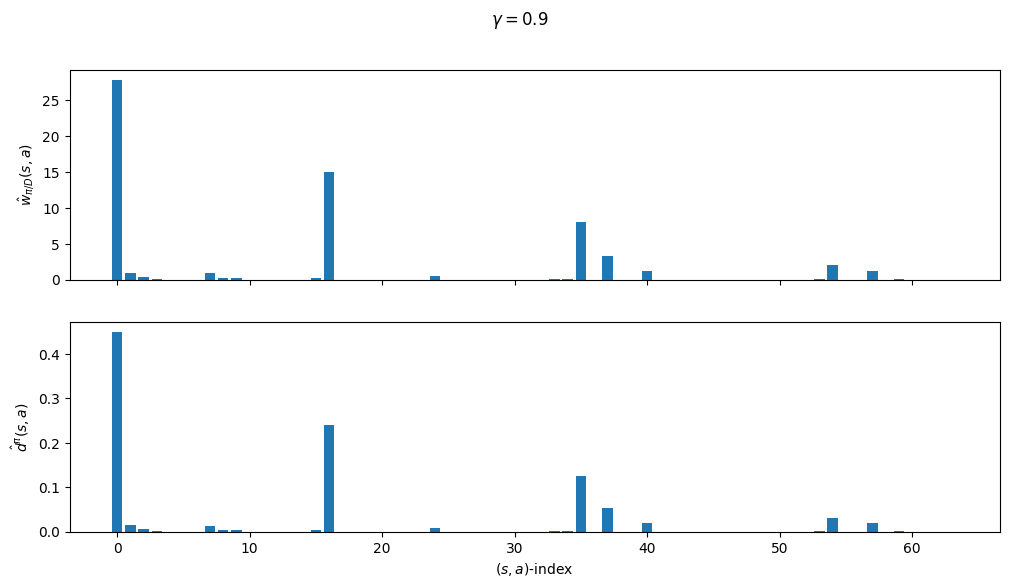

In [587]:
test_estimator(
    estimator_DICE=estimators_DICE["s"][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

In [ ]:
for k in K:
    print(names[k])
    d = get_error_aux_estimates(
        aux_estimates=aux_estimates[k],
        analytical_solver=analytical_solver[k],
    )
    display(d)

deterministic


{'sum': {'d0': 1.220203200326392e-07,
  'dD': 7.751600000000006e-06,
  'P': 9.194384339681043e-09},
 'mean': {'d0': 1.9065675005099874e-09,
  'dD': 1.2111875000000009e-07,
  'P': 2.244722739179942e-12},
 'masked': {'d0': 3.05050800081598e-08,
  'dD': 1.2111875000000009e-07,
  'P': 3.5915563826879074e-11}}

stochastic


{'sum': {'d0': 1.6571244992279378e-07,
  'dD': 1.02318e-05,
  'P': 0.014274415297264136},
 'mean': {'d0': 2.589257030043653e-09,
  'dD': 1.59871875e-07,
  'P': 3.484964672183627e-06},
 'masked': {'d0': 4.1428112480698445e-08,
  'dD': 1.59871875e-07,
  'P': 2.5131012847296012e-05}}